In [4]:
# can be removed if LinOT package is installed via pip
import sys
sys.path.append('../../lib')

import numpy as np

import LinOT
import LinOT.auxiliary as aux
import LinOT.SinkhornNP as Sinkhorn

import matplotlib
import matplotlib.pyplot as plt

matplotlib.rc('image', interpolation='nearest')
matplotlib.rc('figure', facecolor='white')
matplotlib.rc('image', cmap='viridis')

%matplotlib inline

# Compute optimal transport between reference and an individual sample
* compute logarithmic map
* some simple examples with exponential map
* do both for W2 and for HK

## Import and setup

In [5]:
# import two samples and the linear mean
datMu = aux.importMeasure("data/two_ellipses_rad0d25/mean.mat", totalMass=1., keepZero=False)
datNu = aux.importMeasure("data/two_ellipses_rad0d25/sample_000.mat", totalMass=1., keepZero=False)
res = datMu[3]

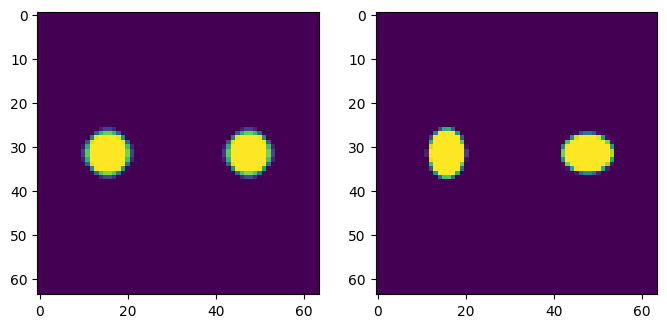

In [6]:
# simple visualization
fig = plt.figure(figsize=(8, 4))
for i, dat in enumerate([datMu, datNu]):
    fig.add_subplot(1, 2, i + 1)
    plt.imshow(dat[0])
plt.show()

In [7]:
mu = datMu[1]
posMu = datMu[2].astype(np.double)

nu = datNu[1]
posNu = datNu[2].astype(np.double)

## Wasserstein-2

In [8]:
params = {}
params["setup_HKMode"] = False
params["solver_errorGoal"] = 1.E-4
params["aux_verbose"] = False
params["solver_epsStart"] = 1E3
params["solver_epsTarget"] = 0.1

In [9]:
# solve W transport
value, pi = Sinkhorn.SolveW2(mu, posMu, nu, posNu,
                             SinkhornError=params["solver_errorGoal"],
                             epsTarget=params["solver_epsTarget"], epsInit=params["solver_epsStart"],
                             returnSolver=False
                             )
# extract approximate Monge map (which is logarithmic map, up to subtracting initial locations)
v = LinOT.LogW2(pi, posMu, posNu, baseLog=None)

In [10]:
# compare transport cost of piA with the approximate one implied by monge map
print("transport cost coupling:\t", value)

valueMonge = np.einsum(v ** 2, [0, 1], mu, [0], [])
print("transport map:\t\t\t", valueMonge)
# the difference between the two values of on the order 1, which corresponds to the discretization scale

transport cost coupling:	 12.751767431484883
transport map:			 11.295105073204466


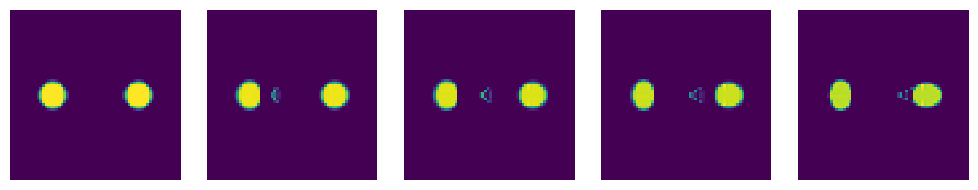

In [11]:
# visualize re-construction of input measure via exponential map
# this will include some numerical artifacts due to:
# discretization and pixels that are split between the two ellipses
tList = np.linspace(0, 1, num=5)
fig = plt.figure(figsize=(10, 2))
for i, t in enumerate(tList):
    img = aux.rasterizePointCloud2d(mu, posMu + t * v, res)
    fig.add_subplot(1, len(tList), i + 1)
    plt.imshow(img)
    plt.axis("off")
plt.tight_layout()
plt.show()

## Hellinger--Kantorovich

In [12]:
params = {}
params["setup_HKMode"] = True
params["setup_HKScale"] = 5
params["solver_errorGoal"] = 1.E-4
params["aux_verbose"] = False
params["solver_epsStart"] = 1E3
params["solver_epsTarget"] = 0.1

In [13]:
# solve HK transport
value, pi = Sinkhorn.SolveHK(mu, posMu, nu, posNu, HKScale=params["setup_HKScale"],
                             SinkhornError=params["solver_errorGoal"],
                             epsTarget=params["solver_epsTarget"], epsInit=params["solver_epsStart"],
                             returnSolver=False
                             )

In [14]:
# from optimal coupling compute tangent vector data
v, alpha = LinOT.LogHK(pi, mu, posMu, posNu,
                       kappa=params["setup_HKScale"],
                       baseLog=None)

In [15]:
# HK embedding from reference mu

embHK = LinOT.LinHKEmbedding(muRef=mu, posRef=posMu,
                             kappa=params["setup_HKScale"])

embHK.addSamples((v, alpha))

In [16]:
# compare transport cost of piA with the approximate one implied by monge map
print("transport cost coupling:\t", value)

vecEucl = embHK.samples[0]
valueMonge = np.sum(vecEucl ** 2)
print("transport map:\t\t\t", valueMonge)
# the difference between the two values of on the order 1, which corresponds to the discretization scale
# now this looks more significant, since the two measures are now much closer to each other

transport cost coupling:	 0.4735332795002504
transport map:			 0.28148083362844833


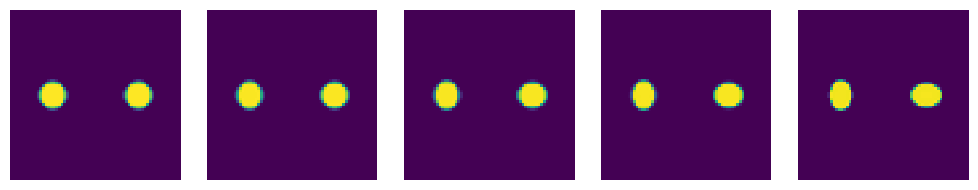

In [17]:
# visualize re-construction of input measure via exponential map
# this will include some numerical artifacts due to discretization
tList = np.linspace(0, 1, num=5)
expMeas = embHK.expEuclidean(vecEucl, tList)
fig = plt.figure(figsize=(10, 2))
for i, (t, (expMu, expT)) in enumerate(zip(tList, expMeas)):
    img = aux.rasterizePointCloud2d(expMu, expT, res)
    fig.add_subplot(1, len(tList), i + 1)
    plt.imshow(img)
    plt.axis("off")
plt.tight_layout()
plt.show()